In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import matplotlib
from PIL import Image
import pyximport
pyximport.install(language_level=3)
from semantic_analysis.knowledge_base import filter_kb_histograms, get_sup_ent_lists
from semantic_analysis.visualization import filter_graphs_with_local_data, RelationshipVisualizer

json_path_kb_histograms = '../COCO/kb/pairwiseKB.json'
charts_path = '../COCO/kb/charts'

if not os.path.isdir(charts_path):
    os.makedirs(charts_path)

with open(json_path_kb_histograms, 'r') as f:
    kb = json.load(f)
maxentr = entropy([1/3,1/3,1/3])
minsup = 64
filtered_kb = filter_kb_histograms(kb, minsup, maxentr)

## Co-occurrence
Some classes co-occur very often in the images (e.g. person, book, car).
During mining process it may be useful to consider "people", "books", "cars".

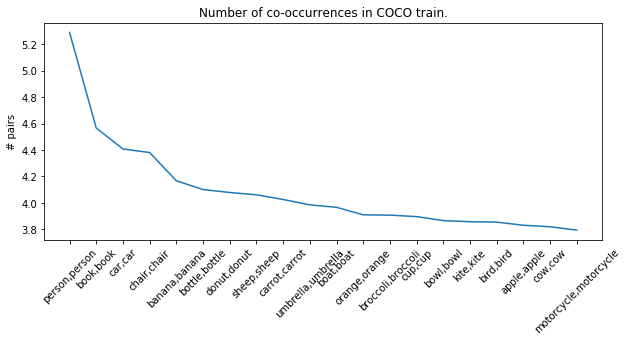

In [2]:
cooccur = sorted([(p,h['sup']) for p, h in kb.items() if p.split(',')[0]==p.split(',')[1]],key=lambda pair: -pair[1])
p = [el[0] for el in cooccur]
s = [el[1] for el in cooccur]
plt.figure(figsize=[10,4])
plt.plot(p[:20],np.log10(s[:20]))
plt.xticks(rotation=45)
plt.ylabel('# pairs')
plt.title('Number of co-occurrences in COCO train.')
plt.show()

The co-occurrence of many objects of the same class may generate different graphs which has poor degree of abstraction.
Let's show two examples of frequent graphs with a lot of "people" inside.

In [3]:
from config import graph_mining_dir
with open(os.path.join(graph_mining_dir, 'train_freqGraph_kbfilter_gspan_01.json')) as f:
    freq_graphs = json.load(f)

In [4]:
def print_graph(g):
    print("Freq graph:")
    string = []
    node_labels = {n['id']:n['label'] for n in g['nodes']}
    for l in g['links']:
        string.append(f"{node_labels[l['s']]}, {l['pos']}, {node_labels[l['r']]}")
    for str_i in string:
        print(str_i)

def has_people(g, freq=4):
    if 'nodes' not in g:
        return False
    node_labels = [n['label'] for n in g['nodes']]
    u_l,c_l = np.unique(node_labels,return_counts=True)
    for u,c in zip(u_l,c_l):
        if u=='person' and c>freq:
            return True
    return False

freq_graph_people = []
for g in freq_graphs:
    if has_people(g['g']):
        freq_graph_people.append(g)
i = 8
print_graph(freq_graph_people[0]['g'])
print_graph(freq_graph_people[1]['g'])

Freq graph:
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, side-down, sky-other-merged
Freq graph:
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged


Information in the graphs above are redundant.
Two better representations would be:

```
Freq graph
People below sky-other-merged
Person side-down sky-other-merged

Freq graph:
People below sky-other-merged
```

## GSpan, Pruned equivalent nodes
- Analysis of results after pruning equivalent nodes.

In [5]:
with open(os.path.join(graph_mining_dir, 'train_freqGraph_kbfilter_prune_gspan_001.json')) as f:
    freq_graphs = json.load(f)

In [6]:
def graphs_with(graphs, classLabel):
    res = []
    for el in graphs:
        found = False
        for n in el['g']['nodes']:
            if n['label']==classLabel:
                found = True
                break
        if found:
            res.append(el)
    return res

graphs_with(freq_graphs, 'floor-other-merged')

[{'g': {'directed': True,
   'graph': {},
   'links': [],
   'multigraph': False,
   'nodes': [{'id': 0, 'label': 'floor-other-merged'}]},
  'sup': 5258},
 {'g': {'directed': True,
   'graph': {},
   'links': [{'pos': 'side-down', 'r': 0, 's': 1}],
   'multigraph': False,
   'nodes': [{'id': 0, 'label': 'sky-other-merged'},
    {'id': 1, 'label': 'floor-other-merged'}]},
  'sup': 136},
 {'g': {'directed': True,
   'graph': {},
   'links': [{'pos': 'below', 'r': 0, 's': 1}],
   'multigraph': False,
   'nodes': [{'id': 0, 'label': 'sky-other-merged'},
    {'id': 1, 'label': 'floor-other-merged'}]},
  'sup': 841},
 {'g': {'directed': True,
   'graph': {},
   'links': [{'pos': 'below', 'r': 0, 's': 1},
    {'pos': 'below', 'r': 0, 's': 2}],
   'multigraph': False,
   'nodes': [{'id': 0, 'label': 'sky-other-merged'},
    {'id': 1, 'label': 'floor-other-merged'},
    {'id': 2, 'label': 'grass-merged'}]},
  'sup': 151},
 {'g': {'directed': True,
   'graph': {},
   'links': [{'pos': 'below', '

In [ ]:
with open(train_graphs_json_path, "r") as f:
    tot_graphs = json.load(f)
graphs = filter_graphs_with_local_data(tot_graphs)

In [323]:
from networkx.algorithms.isomorphism import DiGraphMatcher
from semantic_analysis.graph_utils import json_to_nx
from networkx.algorithms.isomorphism import categorical_node_match, categorical_edge_match

def match_graph(graph, freq_graph, node_matching):
    node_matching = {v:k for k,v in node_matching.items()}
    links = []
    nodes = []
    for edge in freq_graph['links']:
        converted_e = edge.copy()
        converted_e['s']=node_matching[converted_e['s']]
        converted_e['r']=node_matching[converted_e['r']]
        links.append(converted_e)
    for node in freq_graph['nodes']:
        converted_n = node.copy()
        converted_n['id']=node_matching[converted_n['id']]
        nodes.append(converted_n)
    return {'graph':graph['graph'],'directed':True, 'multigraph':False, 'links':links,'nodes':nodes}



def find_results(label, i):
    nmatch = categorical_node_match('label','')
    ematch = categorical_edge_match('pos','')

    fgraph = graphs_with(freq_graphs, label)[i]['g']

    results = []
    for g in graphs:
        matcher = DiGraphMatcher(json_to_nx(g), json_to_nx(fgraph), node_match=lambda n1,n2: n1['label']==n2['label'], edge_match=ematch)
        res = list(matcher.subgraph_isomorphisms_iter())
        if len(res)>0:
            results.append((g, res[0]))
        if len(results)>3:
            break
    return fgraph, results

def plot_results(results, fgraph):
    plt.figure(figsize=[10,8])
    for i,res_i in enumerate(results):
        g_matched = match_graph(res_i[0], fgraph, res_i[1])
        ax = plt.subplot(2,2,i+1)
        rv = RelationshipVisualizer(res_i[0]['graph']['name'], ax)
        rv.draw_positive_relationships(g_matched, kb, 0.0)
    plt.show()

4
[{'label': 'sink', 'id': 0}, {'label': 'light', 'id': 1}]


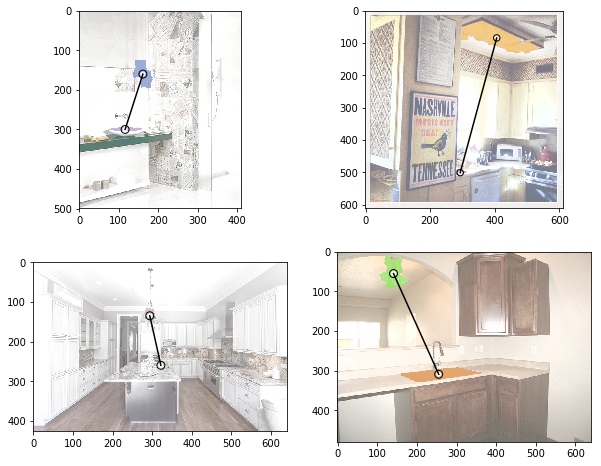

In [430]:
#fgraph, results = find_results('car',1)
#fgraph, results = find_results('oven',5)
#fgraph, results = find_results('tree-merged',4)#3
fgraph, results = find_results('sink',3)#3
print(len(results))
print(fgraph['nodes'])
plot_results(results, fgraph)


2
[{'label': 'chair', 'id': 0}, {'label': 'sky-other-merged', 'id': 1}]


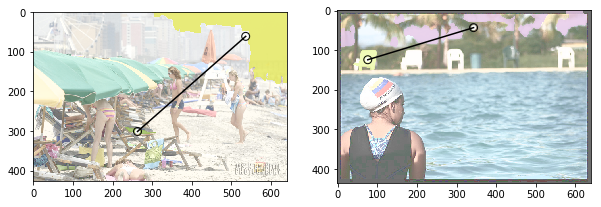

2
[{'label': 'chair', 'id': 0}, {'label': 'ceiling-merged', 'id': 1}, {'label': 'rug-merged', 'id': 2}]


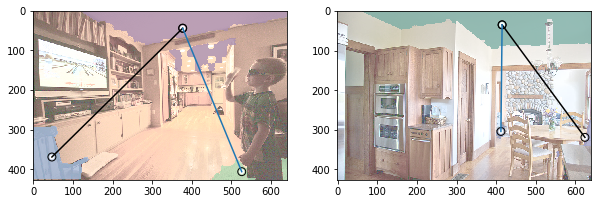

2
[{'label': 'chair', 'id': 0}, {'label': 'mountain-merged', 'id': 1}]


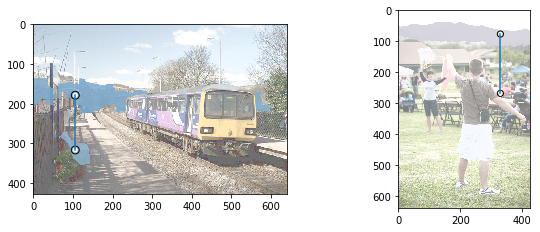

In [358]:
# Sdraio
fgraph, results = find_results('chair',1)
print(len(results))
print(fgraph['nodes'])
plot_results(results, fgraph)
# Sedia
fgraph, results = find_results('chair',4)
print(len(results))
print(fgraph['nodes'])
plot_results(results, fgraph)
# Sedia da esterno
fgraph, results = find_results('chair',9)#3
print(len(results))
print(fgraph['nodes'])
plot_results(results, fgraph)

In [96]:
from panopticapi.utils import load_png_annotation
from semantic_analysis.visualization import RelationshipVisualizer
import cv2

def has_people(g):
    node_labels = [n['label'] for n in g['nodes']]
    u_l,c_l = np.unique(node_labels,return_counts=True)
    for u,c in zip(u_l,c_l):
        if u=='person' and c>10:
            return True
    return False

def print_images(selected):
    plt.figure(figsize=[14,18])
    for i, g in enumerate(selected):
        ax = plt.subplot(3,2,i+1)
        rv = RelationshipVisualizer(g['graph']['name'], ax)
        rv.draw_positive_relationships(g, filtered_kb, 0.1)

# Find first graph with people
for g in graphs:
    if has_people(g):
        break

Freq graph:
building-other-merged, side-up, person
building-other-merged, above, person
building-other-merged, above, person
building-other-merged, on, person
building-other-merged, on, person
car, inside, person
car, inside, person
car, side-up, person
car, side-up, person
grass-merged, hanging, person
grass-merged, hanging, person
grass-merged, hanging, person
grass-merged, side-down, person
grass-merged, around, person
grass-merged, hanging, person
grass-merged, hanging, person
grass-merged, around, person
grass-merged, around, person
grass-merged, hanging, person
grass-merged, around, person
grass-merged, hanging, person
grass-merged, around, person
kite, above, person
kite, above, person
kite, side-up, person
kite, above, person
person, below, sky-other-merged
person, hanging, tree-merged
person, below, sky-other-merged
person, below, tree-merged
person, below, sky-other-merged
person, below, tree-merged
person, below, sky-other-merged
person, side-down, sky-other-merged
person, h

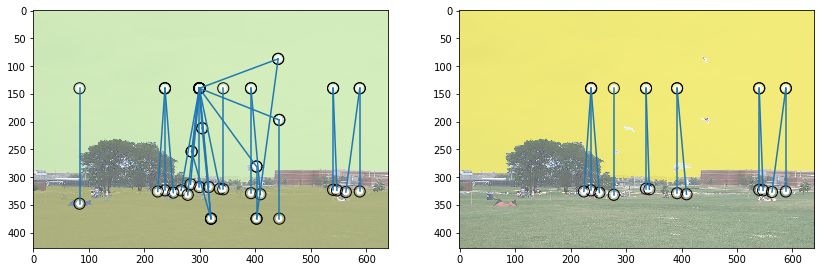

In [98]:
persons = [n for n in g['nodes'] if n['label']=='person']
person_ids = [n['id'] for n in g['nodes'] if n['label']=='person']
g2 = {'graph':g['graph'],'links':[],'nodes':g['nodes']}
for l in g['links']:
    if l['s']in person_ids or l['r']in person_ids:
        g2['links'].append(l)
        
print_images([g, g2])
print_graph(g2)


In [ ]:
Question: how to reduce repetitions?

In [113]:

#Rarely: <0.01
#Notable: >1/3

# def clean_histogram(h):
#     h_clean = {k,v for k,v in h.items() if k!='sup' and k!='entropy' and (v>1/3 or v<0.01)}
#     position_labels -> add zero likelihoods
    
    
# TODO: generare istogrammi puliti e contare quanti sono.
# Valutarne le entropie.

    
# likelihoods = []
# for p,h in json_data.items():
#     h_l = [v for k,v in h.items() if k!='sup' and k!='entropy']
#     likelihoods.extend(h_l)
#     zeros = 9-len(h_l)
#     if zeros>0:
#         likelihoods.extend([0 for i in range(zeros)])
# plt.figure(figsize=[12,4])
# likelihoods = np.array(likelihoods)
# sns.distplot(likelihoods[likelihoods<0.05])
# transform_hist

# def valid(h):
#     check = (np.array(list(h.values()))<0.01).sum()
#     return check>=1 or len(h)<9
# [(p,h) for p,h in json_data.items() if valid(h)]
#json_data['person,tree-merged']
#from scipy.stats import entropy
#entropy([0.4,0.4] + [(1-0.8)/7 for i in range(7)])
#(1-0.4)/7
#1/9

0.3333333333333333

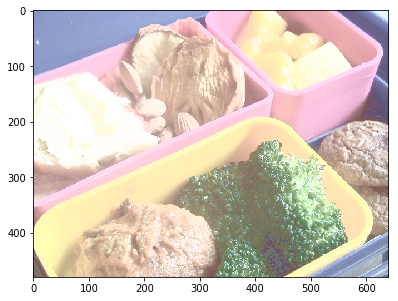